# **Importing libraries**

In [20]:
import json
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tqdm
import os
import skimage
import pickle
import sklearn
from tqdm import tqdm

from skimage.feature import match_descriptors, ORB
from skimage.color import rgb2gray
from sklearn.cluster import KMeans
from skimage.feature import ORB
from skimage.color import rgb2gray
from sklearn import preprocessing

# **Image pre-processing**

## **Images descriptors**

Given an image, `img`, and a the number of key points that we want to sample within this image, `n_keypoints`, the next function computes the image descriptors that will represent the given image.

In [42]:
def get_image_descriptors(img, n_keypoints = 50):
    """
        Input:
            img: image in gray scale format.
            n_keypoints: number of keypoints we want to extract from the image.
        Output:
            descriptors: descriptors (the features vector) for the given image
    """
    # Initialize the ORB descriptor
    descriptor_extractor = ORB(n_keypoints)
    # Extract ORB descriptors
    descriptor_extractor.detect_and_extract(img)  
    # Return the descriptors (the features vector) for the given image
    descriptors = descriptor_extractor.descriptors
    return (descriptors)

## **Clustering**

In [22]:
# clustering
K = 32  # 
num_initialization = 5 # 

def build_words(descriptors, n_clusters = 32, n_init = 5):
    """
        The centroids can be considered as the words that compose our documents: the basic components of the images.

        Input:
            descriptors: descriptors extracted from the map (training) images before.
            num_clusters: number of clusters (equivalent to the number of words) we want to estimate.
            n_init: number of time the k-means algorithm will be run with different centroid seeds.
        Output:
            centroids: words that compose our documents.
    """
    # Run the k-means clustering
    kmeans = KMeans(n_clusters = n_clusters, random_state=0, n_init = n_init, verbose=0)
    clusters = kmeans.fit(descriptors)
    centroids = clusters.cluster_centers_

    return (centroids)

## **Bag-of-words representation**

Given the centroids of a k-means computation and the image descriptors of an image, the next function computes de bag-of-words representation of the given image.

In [35]:
def bag_of_words(centroids, img_descriptors):
    """
        Initialization of the bag of words (BoW) vector
        Note that the BoW vector has length equal to the number of cluster centroids
        The cluster centroids are indeed our visual words, and the BoW will be the
        histogram of these words found in the given image.

        Input:
            centroids: centroids found with the KMeans clustering.
            img_descriptors: descriptors extracted from the image.
        Output:
            bow_vector: bag-of-words representation of the given image.
    """
    n_centroids = centroids.shape[0]
    n_descriptors = img_descriptors.shape[0]

    bow_vector = np.zeros(n_centroids)  
    
    for i in range(n_descriptors):
        matches = match_descriptors(centroids, np.array([img_descriptors[i]]), cross_check=True)
        bow_vector[matches[0][0]] += 1

    return bow_vector

In the next cell, we compute the bag-of-words representation for all the map images.

## **Z-Score normalization**

In [38]:
def zscore_normalize(bow_images):
    """
        Input:
            bow_images: the bag-of-words representation of a image
        Output:
    """
    # Compute z-score statistics
    scaler = preprocessing.StandardScaler().fit(bow_images)
    # Normalize the vectors of the map collection (0 mean and 1 std)
    return(scaler.transform(bow_map_images))

# **Retrieval algorithm**

In [37]:
def retrieve_images(map_bow_vectors, query_bow):
    """
        Function to find the most similar images to the given query image.

        Input:
            map_bow_vectors: bag-of-words vectors of the map images.
            query_bow: bag-of-words vector of the query image.
        Output:
            most_similar: ranked vector of indixes of the most similar images to the query image.
    """
    n_map_bow_vectors = map_bow_vectors.shape[0]
    bow_distances = np.zeros(n_map_bow_vectors)
    most_similar = None

    current_distance = 0
    for i, vector in enumerate(map_bow_vectors):
        bow_distances[i] = np.linalg.norm(query_bow - vector)

    most_similar = np.argsort(bow_distances)

    return most_similar

# **Beggining of execution**

In [26]:
# map
with open("data02/database/database_lite.json","r") as f:
    m_idx = json.load(f)
    m_imgs = np.array(m_idx["im_paths"])
    m_loc=np.array(m_idx["loc"])

# query
with open("data02/query/query_lite.json","r") as f:
    q_idx=json.load(f)
    q_imgs=np.array(q_idx["im_paths"])
    q_loc=np.array(q_idx["loc"])

# loading the relevance judgements
with h5py.File("data02/london_lite_gt.h5","r") as f:
    fovs = f["fov"][:]
    sim = f["sim"][:].astype(np.uint8)

In [27]:
# Initialize the data structure that will contain all the descriptors
descriptors = None
# Loop over map images
for img_name in m_imgs:
    #img = Image.open(os.path.join('data_image_retrieval/', img_name)).convert()
    #img = np.asarray(img)
    img = plt.imread(os.path.join('data02/', img_name))
    img = rgb2gray(img)

    descriptors_img = get_image_descriptors(img, n_keypoints = 50)
    # Accumulate the computed descriptors
    if descriptors is None:
        descriptors = descriptors_img
    else:
        descriptors = np.vstack( (descriptors, descriptors_img))

# We have extracted 50 descriptors per image, for 1000 images. The ORB descriptors have length 256
print(descriptors.shape)

# save descriptors (uncomment if you want to save the computed descriptors)
f = open('data02/ORB-descriptors-map.bin', 'wb')
data = pickle.dump(descriptors, f)
f.close()

(472929, 256)


In [29]:
# load pre-computed descriptors
f = open('data02/ORB-descriptors-map.bin', 'rb')
descriptors = pickle.load(f)
f.close()

In [31]:
centroids_exe = build_words(descriptors, n_clusters = 32, n_init = 5)

print("Shape of the centroids matrix: ", centroids_exe.shape)
print("We computed ", centroids_exe.shape[0], "centroids of lengh ", centroids_exe.shape[1], " (the same of the descriptor)")

Shape of the centroids matrix:  (32, 256)
We computed  32 centroids of lengh  256  (the same of the descriptor)


In [39]:
bow_map_images = None
# loop over the images in the map set
for img_name in tqdm(m_imgs):
    # load image
    img = plt.imread(os.path.join('data02/', img_name))
    img = rgb2gray(img)
    
    # extract the keypoints and corresponding descriptors (50 ORB descriptors)
    img_descriptors = get_image_descriptors(img, n_keypoints = 50)

    # compute BoW representation of the image (using the basic 'words', i.e. centroids, computed earlier)
    bow = bag_of_words(centroids_exe, img_descriptors)
    # add the computed BoW vector to the set of map representations
    if bow_map_images is None:
        bow_map_images = bow
    else:
        bow_map_images = np.vstack( (bow_map_images, bow))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:43<00:00,  9.66it/s]


Indices of similar images retrieved:  [ 81  26 258 851 624 625 621 688 689 114]
Indices of relevant images (given in the GT relevance judgements):  [295 296 297 298 299]


(np.float64(-0.5), np.float64(340.5), np.float64(255.5), np.float64(-0.5))

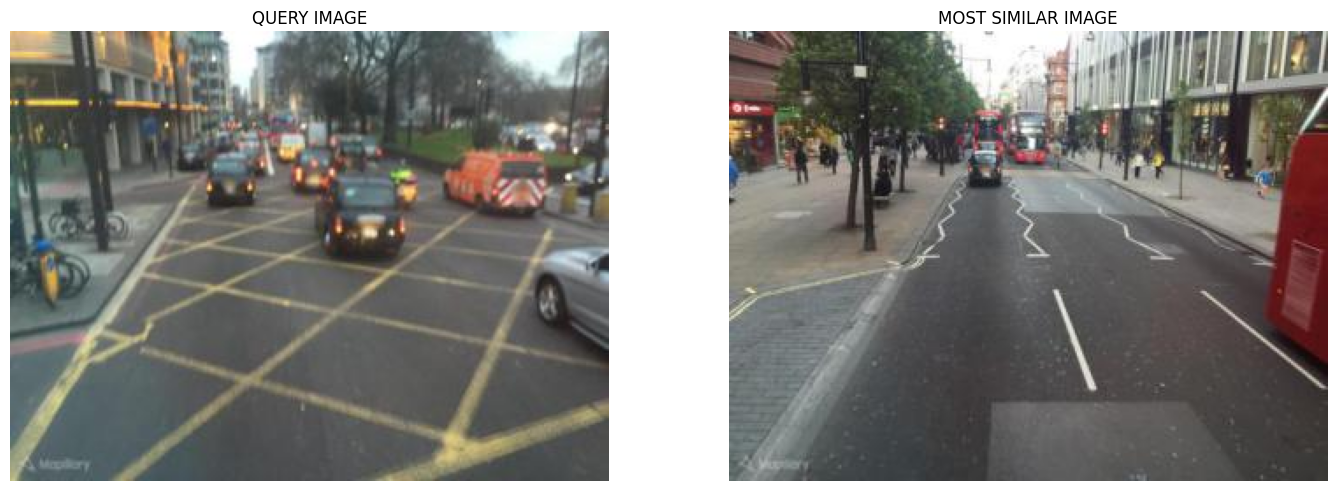

In [67]:

orig_bow_map_images = bow_map_images

bow_map_images = zscore_normalize(bow_map_images)


# Retrieve the most similar images to query image 221 (index 221-1=220)
query_idx = 199 # 220
img = plt.imread("data02/" + q_imgs[query_idx])
# PLOT THE IMAGES ONLY
plt.figure(figsize=(17,10))
plt.subplot(1,2,1)
plt.title('QUERY IMAGE')
plt.imshow(img)
plt.axis("off")

img = rgb2gray(img)

# compute bag of words
query_img_descriptors = get_image_descriptors(img, 50)
bow = bag_of_words(centroids_exe, query_img_descriptors)

# Normalize the query BoW vector using the mean and variance of the map (computed earlier and saved into the scaler object)
scaler = preprocessing.StandardScaler().fit(orig_bow_map_images)
bow = scaler.transform(bow.reshape(-1, 1).transpose())
bow = bow.transpose().reshape(-1)

# Retrieve the indices of the top-10 similar images from the map
retrieved_images = retrieve_images(bow_map_images, bow)
print('Indices of similar images retrieved: ', retrieved_images[:10])
# Indices of the relevant map images for the query: we have the relevance judgements (Ground truth)
relevant_images = np.where(sim[query_idx, :] == 1)[0]
print('Indices of relevant images (given in the GT relevance judgements): ', relevant_images)

plt.subplot(1,2,2)
plt.title('MOST SIMILAR IMAGE')
plt.imshow(plt.imread("data02/" + q_imgs[relevant_images[0]]))
plt.axis("off")